Main resource: https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_7_TRAINING_A_MODEL.md

In [1]:
import flair
import numpy as np
import pandas as pd
import torch
from torch.optim.adam import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
flair.device = device

print(flair.device)

cuda


In [2]:
print(torch.__version__)

1.7.1+cu110


In [3]:
from flair.data import Corpus
from flair.datasets import CSVClassificationCorpus
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings, TransformerDocumentEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer

data_folder = '../data/corpus_10042021'
column_name_map = {1: "text", 2: "label_topic"}

# 1. get the corpus
corpus: Corpus = CSVClassificationCorpus(data_folder,
                                         column_name_map,
                                         skip_header=True) 

# 2. create the label dictionary
label_dict = corpus.make_label_dictionary()

print(label_dict)

2021-04-26 21:14:35,530 Reading data from ..\data\corpus_10042021
2021-04-26 21:14:35,531 Train: ..\data\corpus_10042021\train.csv
2021-04-26 21:14:35,532 Dev: ..\data\corpus_10042021\dev.csv
2021-04-26 21:14:35,532 Test: ..\data\corpus_10042021\test.csv
2021-04-26 21:14:35,548 Computing label dictionary. Progress:


100%|██████████████████████████████████████████████████████████████████████████████████| 976/976 [00:01<00:00, 853.81it/s]

2021-04-26 21:14:54,210 [b'High', b'Low', b'Medium']
Dictionary with 3 tags: High, Low, Medium


In [5]:
# 4. initialize document embedding by passing list of word embeddings
document_embeddings = TransformerDocumentEmbeddings('roberta-base', fine_tune=True)

# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)

# 6. initialize the text classifier trainer
trainer = ModelTrainer(classifier, corpus, optimizer=Adam)

# 7. start the training
trainer.train('./flair/roberta',
              learning_rate=3e-5, # use very small learning rate
              mini_batch_size=4,
              mini_batch_chunk_size=2, # optionally set this if transformer is too much for your machine
              max_epochs=10, # terminate after 10 epochs)
              train_with_dev=True,
              patience=3,
              monitor_test=True,
              embeddings_storage_mode='gpu') 

2021-04-26 21:17:52,493 ----------------------------------------------------------------------------------------------------
2021-04-26 21:17:52,495 Model: "TextClassifier(
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_feature

{'test_score': 0.4037,
 'dev_score_history': [],
 'train_loss_history': [1.1435012030796927,
  1.060681430164908,
  1.095363898966156,
  1.087712670203115,
  1.0932405918348032,
  1.0661262510741343,
  0.9859592353955644,
  0.8474329927073578,
  0.7711241665300074,
  0.6888509894870068],
 'dev_loss_history': []}

2021-04-26 21:35:48,508 ----------------------------------------------------------------------------------------------------
2021-04-26 21:35:48,508 WARNING: No F1 found for test split in this data.
2021-04-26 21:35:48,509 Are you sure you want to plot F1 and not another value?
2021-04-26 21:35:48,510 ----------------------------------------------------------------------------------------------------


No handles with labels found to put in legend.


Loss and F1 plots are saved in flair\roberta\training.png


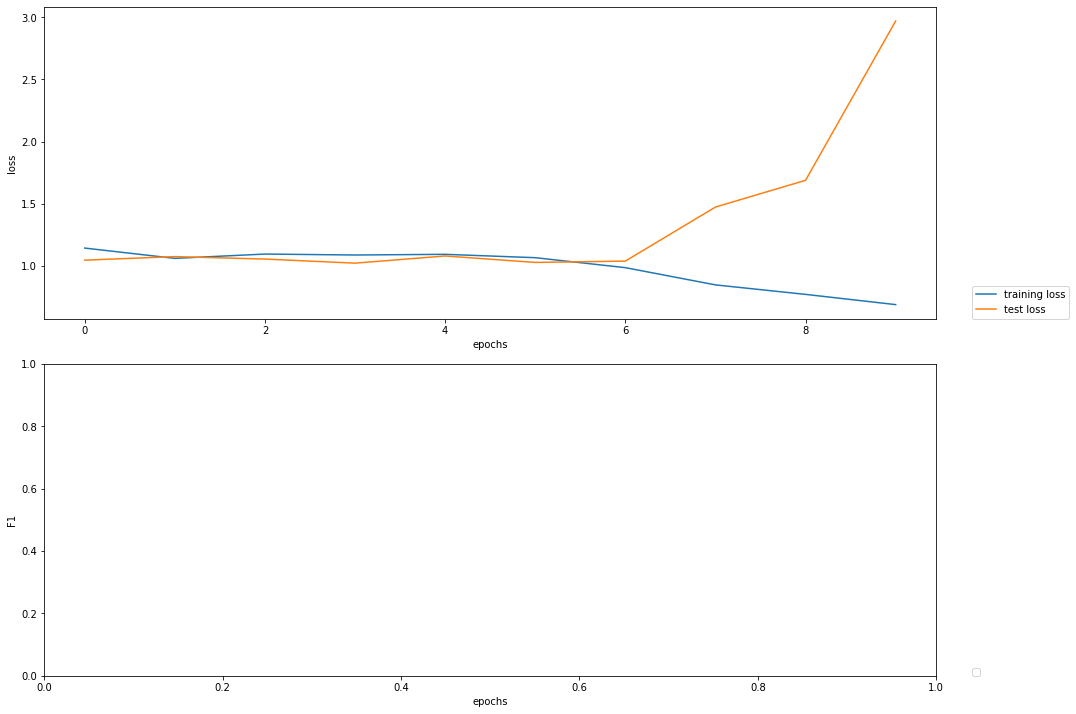

In [6]:
# visualize
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_training_curves('./flair/roberta/loss.tsv')

#This generates PNG plots in the result folder.

In [7]:
test_csv = pd.read_csv('../data/corpus_10042021/test.csv')
test_csv.head()

,Unnamed: 0,Response,Concrete
0,397,Feeling isolated and very fearful at beginni...,Medium
1,32,1. I feel isolated and lonely. \n2. I call my ...,Medium
2,360,I make an effort to message people and suggest...,Low
3,321,I would like to feel more connected to other p...,Low
4,258,I take the time to write out a message to my f...,Medium


In [9]:
from flair.data import Sentence

test_data = []
target = []
preds = []

for i, item in test_csv.iterrows():
    test_data.append(Sentence(item.Response))
    target.append(item.Concrete)
    
classifier.predict(test_data, mini_batch_size=4)

for item in test_data:
    preds.append(item.labels[0].value)

C:\Users\magab\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['Low', 'Medium', 'High'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


[Text(0, 0.5, 'Low'), Text(0, 1.5, 'Medium'), Text(0, 2.5, 'High')]

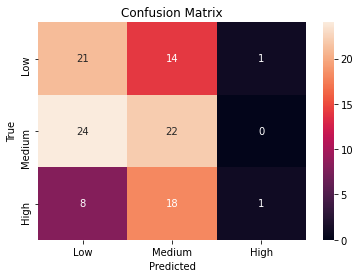

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['Low', 'Medium', 'High']
cm = confusion_matrix(target, preds, labels)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)